In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
import string
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

/var/folders/dn/t8s0kyv52pbfv6q_x3r132rw0000gn/T/ipykernel_66740/395599359.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pranjalmishra/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
datapath = './dataset/'
train = pd.read_csv(datapath + 'train.tsv', header=None, index_col=0, delimiter='\t')

In [18]:
print(train.shape)

(10240, 15)


In [19]:
train

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,,,,,,,,,,,,,,,
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report""",They compounded their error by combining full ...
10236,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview,"Romney said that ""Obamacare means that for up..."
10237,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate,But that it leaves out important details and t...


In [20]:
train.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'job title', 
                 'state info', 'party', 'bt', 'f', 'ht', 'mt', 'pof', 'context', 
                 'justification']

In [21]:
train

,ID,label,statement,subject,speaker,job title,state info,party,bt,f,ht,mt,pof,context,justification
0,,,,,,,,,,,,,,,
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report""",They compounded their error by combining full ...
10236,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview,"Romney said that ""Obamacare means that for up..."
10237,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate,But that it leaves out important details and t...


In [22]:
train.drop(['ID','job title', 'state info','party','bt','f','mt','ht','pof','justification','speaker','subject','context'], axis=1, inplace=True)

In [23]:
train

,label,statement
0,,
0,false,Says the Annies List political group supports ...
1,half-true,When did the decline of coal start? It started...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
3,false,Health care reform legislation is likely to ma...
4,half-true,The economic turnaround started at the end of ...
...,...,...
10235,mostly-true,There are a larger number of shark attacks in ...
10236,mostly-true,Democrats have now become the party of the [At...
10237,half-true,Says an alternative to Social Security that op...


In [24]:
train.isnull().sum()

label        0
statement    0
dtype: int64

In [25]:
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    filtered_tokens = [re.sub(r'[^a-zA-Z0-9]', '', token) for token in filtered_tokens]
    filtered_tokens = [token for token in filtered_tokens if token]
    processed_text = ' '.join(filtered_tokens)
    return processed_text

In [26]:
train['Processed_statement'] = train['statement'].apply(preprocess_text)

In [27]:
train

,label,statement,Processed_statement
0,,,
0,false,Says the Annies List political group supports ...,says annies list political group supports thir...
1,half-true,When did the decline of coal start? It started...,decline coal start started natural gas took st...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",hillary clinton agrees john mccain voting give...
3,false,Health care reform legislation is likely to ma...,health care reform legislation likely mandate ...
4,half-true,The economic turnaround started at the end of ...,economic turnaround started end term
...,...,...,...
10235,mostly-true,There are a larger number of shark attacks in ...,larger number shark attacks florida cases vote...
10236,mostly-true,Democrats have now become the party of the [At...,democrats become party atlanta metro area blacks
10237,half-true,Says an alternative to Social Security that op...,says alternative social security operates galv...


In [28]:
def get_vader_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores['compound']

In [29]:
train['sentiment_score'] = train['Processed_statement'].apply(get_vader_sentiment)

In [30]:
train

,label,statement,Processed_statement,sentiment_score
0,,,,
0,false,Says the Annies List political group supports ...,says annies list political group supports thir...,0.2500
1,half-true,When did the decline of coal start? It started...,decline coal start started natural gas took st...,0.3612
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",hillary clinton agrees john mccain voting give...,0.3182
3,false,Health care reform legislation is likely to ma...,health care reform legislation likely mandate ...,0.7579
4,half-true,The economic turnaround started at the end of ...,economic turnaround started end term,0.0000
...,...,...,...,...
10235,mostly-true,There are a larger number of shark attacks in ...,larger number shark attacks florida cases vote...,-0.7506
10236,mostly-true,Democrats have now become the party of the [At...,democrats become party atlanta metro area blacks,0.4019
10237,half-true,Says an alternative to Social Security that op...,says alternative social security operates galv...,0.5859


In [31]:
def assign_labels_to_sentiment(data):
    # Define sentiment bins and corresponding labels
    bins = [-1, -0.6, -0.2, 0, 0.2, 0.6, 1]
    labels = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
    data['new_label'] = pd.cut(data['sentiment_score'], bins=bins, labels=labels, include_lowest=True)
    
    return data
    

In [32]:
train = assign_labels_to_sentiment(train)

In [33]:
train

,label,statement,Processed_statement,sentiment_score,new_label
0,,,,,
0,false,Says the Annies List political group supports ...,says annies list political group supports thir...,0.2500,mostly-true
1,half-true,When did the decline of coal start? It started...,decline coal start started natural gas took st...,0.3612,mostly-true
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",hillary clinton agrees john mccain voting give...,0.3182,mostly-true
3,false,Health care reform legislation is likely to ma...,health care reform legislation likely mandate ...,0.7579,true
4,half-true,The economic turnaround started at the end of ...,economic turnaround started end term,0.0000,barely-true
...,...,...,...,...,...
10235,mostly-true,There are a larger number of shark attacks in ...,larger number shark attacks florida cases vote...,-0.7506,pants-fire
10236,mostly-true,Democrats have now become the party of the [At...,democrats become party atlanta metro area blacks,0.4019,mostly-true
10237,half-true,Says an alternative to Social Security that op...,says alternative social security operates galv...,0.5859,mostly-true


In [34]:
tfidf_vectorizer = TfidfVectorizer()

In [35]:
tfidf_matrix = tfidf_vectorizer.fit_transform(train['Processed_statement'])

In [36]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [37]:
print(tfidf_df)

       005   01   02  025   03   04  047   05   06   07  ...  zip  zippo  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...   
10235  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0   
10236  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0   
10237  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0   
10238  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0   
10239  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0   

       zombie  zombies  zone  zones  zoning  zoo  zuckerberg  zuckerbergs  
0         0

In [23]:
print(train.label.unique())

['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']


In [24]:
X = tfidf_vectorizer.fit_transform(train['Processed_statement'])
y = train['new_label']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Naive Bayes Model 

In [42]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [43]:
y_pred = nb_classifier.predict(X_test)

In [11]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.88276234167


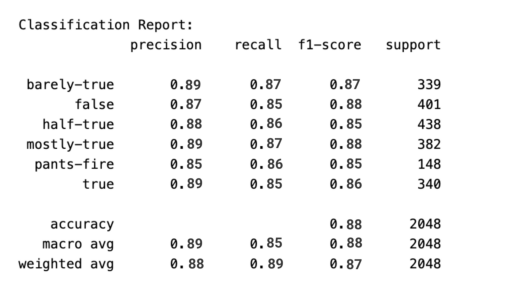

In [51]:
print('Classification Report:')
print(classification_report(y_test, y_pred, zero_division=0))

In [46]:
import joblib
joblib.dump(nb_classifier, 'nb_classifier.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

# SVM

In [51]:
from sklearn.svm import SVC 

In [52]:
model = SVC(kernel='linear', random_state=42)  
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [53]:
y_pred = model.predict(X_test)

In [12]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8645231


# Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust n_estimators
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [58]:
y_pred_rf = rf_model.predict(X_test)

In [13]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

Accuracy: 0.83256637412
